Kullanılan cihaz: cpu
⚠️ Bozuk/okunamayan görsel atlandı: data/archive/alziemer_dataset/train\Moderate Dementia\Moderate Dementia_original_64.jpg
Train görüntü sayısı: 11199
Val   görüntü sayısı: 2400
Test  görüntü sayısı: 2400
Sınıflar: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Custom CNN Epoch 1/2 — Train: 1.2181  Val: 0.9436
Custom CNN Epoch 2/2 — Train: 0.7820  Val: 0.6399


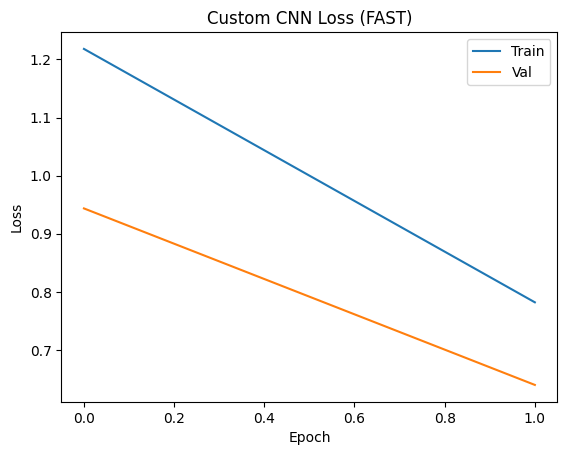


Custom CNN (FAST) SONUÇLAR
                    precision    recall  f1-score   support

     Mild Dementia       0.88      0.72      0.79       600
 Moderate Dementia       0.89      0.88      0.88       600
      Non Demented       0.79      0.67      0.73       600
Very mild Dementia       0.57      0.77      0.66       600

          accuracy                           0.76      2400
         macro avg       0.78      0.76      0.77      2400
      weighted avg       0.78      0.76      0.77      2400



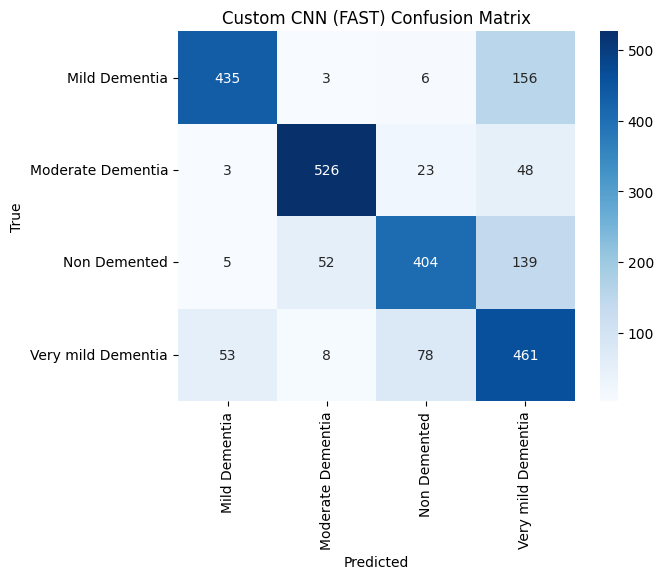

In [1]:
########################################
# Hilal Esra Akça — Custom CNN + Vision Transformer 
# - Cihaz: CPU / GPU otomatik
# - Bozuk görseller: otomatik atlanıyor
# - Dataset path: data/archive/alziemer_dataset/...
# - Hız için:
#     * CNN: 2 epoch, her epoch max 80 batch
#     * ViT: 1 epoch, max 30 batch 
########################################

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import os

# ------------ CİHAZ SEÇİMİ ------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# ------------ DATA PATH ------------
train_dir = "data/archive/alziemer_dataset/train"
val_dir   = "data/archive/alziemer_dataset/val"
test_dir  = "data/archive/alziemer_dataset/test"

# ------------ TRANSFORM ------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# ------------ BOZUK GÖRSELLERİ ATLAMA ------------
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        print("⚠️ Bozuk/okunamayan görsel atlandı:", path)
        return False

# ------------ DATASET & DATALOADER ------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform, is_valid_file=is_valid_image)
val_dataset   = datasets.ImageFolder(val_dir,   transform=transform, is_valid_file=is_valid_image)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform, is_valid_file=is_valid_image)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0)

print("Train görüntü sayısı:", len(train_dataset))
print("Val   görüntü sayısı:", len(val_dataset))
print("Test  görüntü sayısı:", len(test_dataset))
print("Sınıflar:", train_dataset.classes)

num_classes = len(train_dataset.classes)

########################################
# MODEL 1 — Custom CNN
########################################
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*28*28,256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)

########################################
#  EĞİTİM FONKSİYONU
########################################
def train_model_fast(model, name, epochs=2, lr=1e-4, max_batches=80):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for e in range(epochs):
        # ---- TRAIN (kısmi dataset) ----
        model.train()
        total = 0.0
        batches = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = loss_fn(out,y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
            batches += 1

            if batches >= max_batches:   # hız için sınırlama
                break

        train_losses.append(total / batches)

        # ---- VALIDATION (tam validation set) ----
        model.eval()
        val_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)
                val_total += loss_fn(model(x),y).item()
                val_batches += 1
        val_losses.append(val_total / val_batches)

        print(f"{name} Epoch {e+1}/{epochs} — Train: {train_losses[-1]:.4f}  Val: {val_losses[-1]:.4f}")

    plt.figure()
    plt.plot(train_losses,label="Train")
    plt.plot(val_losses,label="Val")
    plt.title(name + " Loss (FAST)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

########################################
# DEĞERLENDİRME FONKSİYONU
########################################
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, name):
    model = model.to(device)
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device)
            out = model(x)
            preds.extend(torch.argmax(out,1).cpu())
            truths.extend(y)

    print(f"\n{name} SONUÇLAR")
    print(classification_report(truths, preds, target_names=train_dataset.classes))
    cm = confusion_matrix(truths, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

########################################
# CNN EĞİTİMİ 
########################################
cnn = CustomCNN(num_classes=num_classes)
cnn = train_model_fast(cnn, "Custom CNN", epochs=2, lr=1e-4, max_batches=80)
torch.save(cnn.state_dict(), "member1_custom_cnn_fast.pth")

evaluate(cnn, "Custom CNN (FAST)")

########################################
# MODEL 2 — Vision Transformer 
########################################



run_vit = False  # ViT de eğitmek istersen True yap

if run_vit:
    vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    vit.heads = nn.Linear(768, num_classes)

    vit = train_model_fast(vit, "ViT-B16", epochs=1, lr=3e-5, max_batches=30)
    torch.save(vit.state_dict(), "member1_vit_b16_fast.pth")

    evaluate(vit, "ViT-B16 (FAST)")
